In [1]:
import pathlib
import sys
import os
import platform

#from time import time
#import scipy

import requests

import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as cx

import seaborn as sns

import datetime

from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib
import matplotlib as mpl
import matplotlib.cm as cm
%matplotlib inline


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis310\lib\site-packages\pyproj\__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
print("Operating System " + platform.system() + " " + platform.release())
print("Python Version " + str(sys.version))
print("Numpy Version " + str(np.__version__))
print (os.environ['CONDA_DEFAULT_ENV'])

Operating System Windows 10
Python Version 3.10.4 | packaged by conda-forge | (main, Mar 24 2022, 17:34:17) [MSC v.1929 64 bit (AMD64)]
Numpy Version 1.21.6
pygis310


In [3]:
sys.path.append('G:/My Drive/Python')
import dbconnect
api_key = dbconnect.openetapi()

* [Documentation](https://open-et.github.io/docs/build/html/index.html)
* [Swagger Docs](https://openet.dri.edu/docs) 
* [API Key Found Here](https://auth.etdata.org/)

In [4]:
def call_api(endpoint, api_key, args=None, get=True):
    """Using user specified inputs, returns data from OpenET Raster API.

    Args:
        endpoint (str): Raster API endpoint

        api_key (str): Required api access key

        args (dictionary): User specified arguments for api call
        
        get (bool): use True if a get request and False if a post request

    Returns:
        result (object): An object of Raster API results
    """

    if args:
        args = args
    else:
        args = {}
    
    # api server address
    server = 'https://openet.dri.edu/'

    # initialize request url
    url = server + endpoint

    # create header
    header = {"Authorization": api_key}

    if get:
        # make api get request
        resp = requests.get(url=url, headers=header, params=args, verify=False)

    else: 
        # make api post request
        resp = requests.post(url=url, headers=header, data=json.dumps(args), verify=False)

    # view results
    print(resp.url)
    print(resp.content)
    return resp


def pull_point_et(yearst = 2016, yearend = 2021, latitude = 39, longitude = -112):
    import time
    args = {'start_date' : f'{yearst}-01-01',                                 # inclusive starting date
            'end_date'   : f'{yearend}-12-31',                                 # inclusive completion date
            # spatial options
            'lon' : longitude,      # longitude,latitude region
            'lat' : latitude,
            'interval' : 'daily',
            'output_file_format':'json',
            # OpenET options
            'variable'      : 'et',                                    # variable to retrieve (ndvi, etof, eto, et, pr)
            'model'         : 'ensemble',                                # model selection (ensemble, geesebal, ssebop, eemetric, sims, disalexi, ptjpl)
            'ref_et_source' : 'gridmet',                                 # reference et collection (cimis, gridmet)
            'provisional' : True,
            # data processing options
            'pixel_aggregation' : 'sum',                                # spatial aggregation method
            'units'             : 'english'}

    # query result
    resp = call_api('raster/timeseries/point?', api_key=api_key, args=args, get=True)
    time.sleep(5)
    etdf = pd.DataFrame(resp.json())
    etdf['time'] = pd.to_datetime(etdf['time'])
    return etdf.set_index('time')

Pull Daily data for 2020 growing season

In [5]:
args = {
  "model": "ensemble",
  "variable": "et",
  "start_date": "2020-03-01",
  "end_date": "2020-10-31",
  "ref_et_source": "gridmet",
  "units": "metric",
  "shapefile_asset_id": "projects/ee-paulinkenbrandt/assets/cottonwood_pou",
  "interval": "daily", 
  "include_columns":"ID",
  "filename_suffix":"cottonwood_dly_et",
  "output_file_format": "csv"
}
#resp = call_api("/raster/timeseries/multipolygon", api_key, args=args)

# Read In Data

## Set the paths to the data

In [6]:
gispath = pathlib.Path("G:/Shared drives/UGS_Groundwater/Projects/Eddy_Covariance/GIS")
ctnpath = gispath / "Cottonwood"
dlypath = ctnpath / "openet_daily_data"
timepath = ctnpath / "openet_data"

## Bring in the GIS File for the fields

In [7]:
ecdb = gispath / "cottonwood_meters.gdb"
pou = gpd.read_file(ecdb, driver='FileGDB', layer='Placeofuse') 

# Reproject to a projection that preserves area
pou = pou.to_crs("EPSG:6350")

# Create dictionaries that match field ID to meter number and area
meternumbers = pou[['ID','Meternumber']].set_index('ID').to_dict()['Meternumber']
pou['acres'] = pou.geometry.area * 0.000247105
acrenums = pou[['ID','acres']].set_index('ID').to_dict()['acres']

# dissolve by meter
pou_diss = pou.dissolve(by='Meternumber').drop(['Shape_Length', 'Shape_Area','Croptype', 'Diversion','Depletion','Acreage','ID'],axis=1)

# Plot the GIS data
pou.plot()


KeyError: "['Croptype', 'Diversion', 'Depletion'] not found in axis"

## Bring in the Output from the Multipolygon Query from the OpenET API

In [ ]:
def summarizeoet(key, dfs, add_area=False):
    """Summarizes and transposes data from the OpenET API"""
    colnm = key.split("_")[-2:]
    colnm[0] = colnm[0][:3]
    col_name = "_".join(colnm)
    
    df = dfs[key]
    df['time'] = pd.to_datetime(df['time'])
    dfgm = df[df['time'].dt.month.isin([3,4,5,6,7,8,9,10])]
    dfgm['year'] = dfgm['time'].dt.year
    dfyr = dfgm.groupby(['ID','year']).sum(numeric_only=True)#.unstack(1)

    dfyr = dfyr.drop('area_hectares',axis=1)#.droplevel(0,axis=1)
    
    return dfyr

In [9]:
dfs = {}

for file in timepath.glob("*"):
    dfs[file.name.split(".")[0]] = pd.read_csv(file,parse_dates=True)
    
flat = {}
for key in dfs.keys():
    colnm = key.split("_")[-2:]
    colnm[0] = colnm[0][:3]
    col_name = "_".join(colnm)
    
    flat[col_name] = summarizeoet(key,dfs)
hectars = summarizeoet(key,dfs)

C:\Users\paulinkenbrandt\AppData\Local\Temp\ipykernel_17240\193751317.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfgm['year'] = dfgm['time'].dt.year
C:\Users\paulinkenbrandt\AppData\Local\Temp\ipykernel_17240\193751317.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfgm['year'] = dfgm['time'].dt.year
C:\Users\paulinkenbrandt\AppData\Local\Temp\ipykernel_17240\193751317.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

Pull all monthly multipolygon data together into one file and calculate effective ET.  Group individual fields into groups of fields fed by the same meters.

In [10]:
data = pd.concat(flat,axis=1).droplevel(-1,axis=1)

for col in data:
    if "_et" in col or "_pr" in col:
        print(col)
        data[col] = data[col]*0.00328084

#calculate the effective et, which is ET minus precipitation
data['eem_eet'] = data['eem_et'] - data['ens_pr']
data['sse_eet'] = data['sse_et'] - data['ens_pr']
data['ens_eet'] = data['ens_et'] - data['ens_pr']
data['sensor'] = data.reset_index().set_index("ID").index.map(meternumbers)
data['acres'] = data.reset_index().set_index("ID").index.map(acrenums)
data = data.reset_index().groupby(['sensor','year']).sum()

data

sse_et
ens_etof
ens_eto
ens_et
ens_pr
eem_et


ID    sse_et  ens_etof   ens_eto    ens_et    ens_pr    eem_et  \
sensor year                                                                    
BC1    2016  129  1.981999  0.016644  3.681008  2.395319  0.539273  2.504585   
       2017  129  2.020498  0.018280  3.591107  2.529658  0.300039  2.502491   
       2018  129  2.141300  0.016595  3.939586  2.534194  0.447687  2.381485   
       2019  129  2.185294  0.017903  3.593560  2.487260  0.514366  2.613433   
       2020  129  2.518997  0.016776  3.923278  2.613794  0.151215  2.835681   
...          ...       ...       ...       ...       ...       ...       ...   
UM8    2018  137  3.375217  0.028553  7.839021  4.452478  0.947125  4.970926   
       2019  137  3.916687  0.035959  7.189862  4.990611  0.944268  5.819405   
       2020  137  4.480877  0.032273  7.847091  4.953495  0.328915  6.221944   
       2021  137  3.327527  0.030583  7.317622  4.411404  1.036809  5.187420   
       2022  137  2.997694  0.029766  7.285177  4.245576  0.698954  5.016402   

              eem_eet   sse_eet   ens_eet      acres  
sensor year                                           
BC1    2016  1.965312  1.442726  1.856046  10.636613  
       2017  2.202452  1.720458  2.229619  10.636613  
       2018  1.933798  1.693613  2.086508  10.636613  
       2019  2.099067  1.670928  1.972894  10.636613  
       2020  2.684466  2.367783  2.462580  10.636613  
...               ...       ...       ...        ...  
UM8    2018  4.023801  2.428092  3.505353  65.928289  
       2019  4.875137  2.972419  4.046343  65.928289  
       2020  5.893029  4.151962  4.624579  65.928289  
       2021  4.150611  2.290719  3.374595  65.928289  
       2022  4.317448  2.298740  3.546622  65.928289  

[1246 rows x 11 columns]

In [1]:
Ptotal = 8
ETc = 6
D = 4

SF = (0.531747 + 0.295164 * D - 0.057697*D**2 + 0.003804*D**3)
Peff = SF * (0.70917*Ptotal**0.82416 - 0.11556)*(10**(0.02426*ETc))
print(SF, Peff)

1.0327069999999998 5.516148983587565


## Read in Tabulated Meter Data from the Emery Water Conservancy District Website (http://www.ewcd.org/)

In [11]:
meter_read = pd.read_excel(ctnpath / 'IRR_totals.xlsx')
#meter_read['sensor-year'] = meter_read[['sensor','year']].apply(lambda x: f"{x[0]}_{x[1]}",1)
meter_read= meter_read.set_index(['sensor','year']).sort_index()
meter_read

total_acft  page_num              comment
sensor year                                           
BC1    2015        48.9     11576                  NaN
       2016        82.8     11576                  NaN
       2017        76.0     11576                  NaN
       2018       107.9     11576                  NaN
       2019       105.9     11576                  NaN
...                 ...       ...                  ...
UM9    2018         6.6     12157                  NaN
       2019        15.7     12157  2019-12-09 00:00:00
       2020        19.0     12157                  NaN
       2021        14.0     12157                  NaN
       2022         0.3     12157                  NaN

[965 rows x 3 columns]

## Combine OpenET data with Meter Data

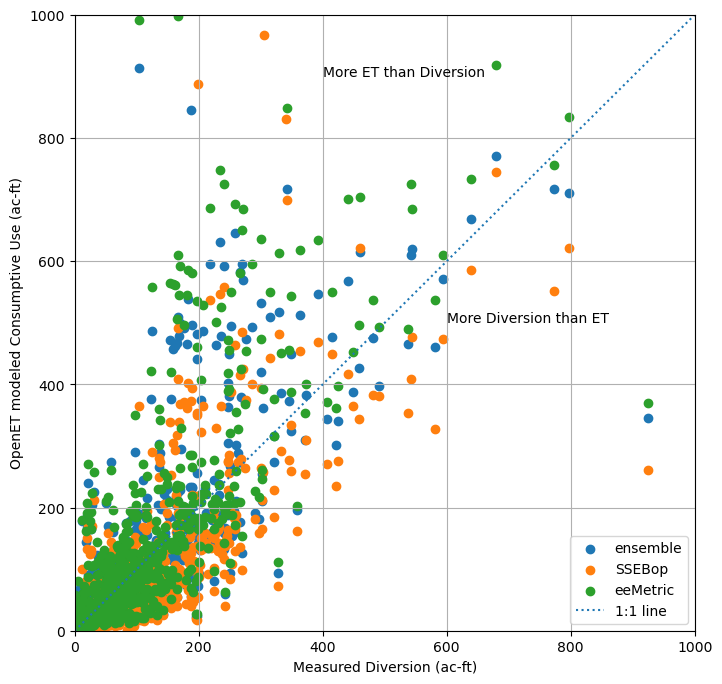

In [30]:
data_all = pd.merge(data,meter_read, left_index=True, right_index=True,copy=True)#how='outer'

for col in data_all:
    if "_et" in col or "_pr" in col or "_eet" in col:
        data_all[f"{col}"] = data_all[col]*data_all['acres']


        
data_all['ens_residual'] =  data_all['total_acft'] - data_all['ens_eet']
data_all['eem_residual'] =  data_all['total_acft'] - data_all['eem_eet']
data_all['sse_residual'] =  data_all['total_acft'] - data_all['eem_eet']

data_all['ens_resid_pcnt_eet'] = data_all['ens_residual']/data_all['ens_eet']

data_all = data_all.reset_index()
data_all['irr_area'] = data_all['sensor'].apply(lambda x: x[:2],1)
data_all = data_all.set_index(['sensor','year'])


fig, ax = plt.subplots(1,1,figsize=(8,8))

plt.scatter(data_all['total_acft'], data_all['ens_eet'],label='ensemble')
plt.scatter(data_all['total_acft'], data_all['sse_eet'],label='SSEBop')
plt.scatter(data_all['total_acft'], data_all['eem_eet'],label='eeMetric')
plt.ylabel('OpenET modeled Consumptive Use (ac-ft)')
plt.xlabel('Measured Diversion (ac-ft)')
plt.text(400,900, "More ET than Diversion")
plt.text(600,500, "More Diversion than ET")
plt.xlim(0,1000)
plt.ylim(0,1000)
plt.plot(range(0,1000),range(0,1000),linestyle=':', label="1:1 line")
plt.grid()
plt.legend()
plt.savefig(gispath / 'consumption_vs_diversion.pdf')
plt.savefig(gispath / 'consumption_vs_diversion.jpg')

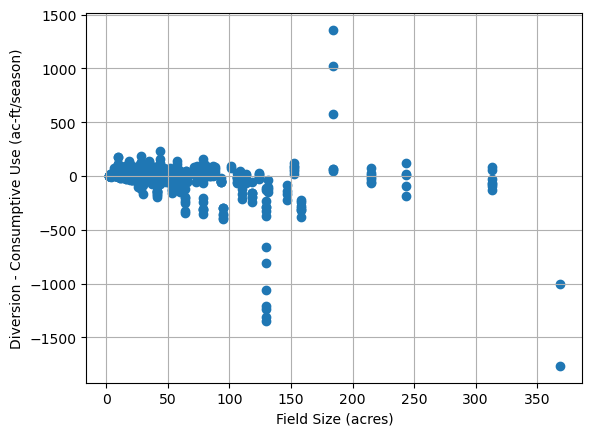

In [32]:
plt.scatter(data_all['acres'],data_all['ens_residual'])
plt.xlabel('Field Size (acres)')
plt.ylabel('Diversion - Consumptive Use (ac-ft/season)')
plt.grid()

Text(0.5, 9.444444444444438, 'Diverted-Consumed (ac-ft)')

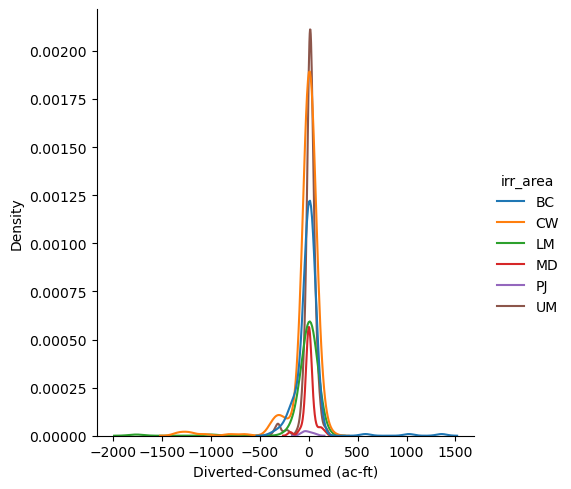

In [18]:
sns.displot(data = data_all, x="ens_residual",hue='irr_area',kind="kde" )
plt.xlabel("Diverted-Consumed (ac-ft)")

Text(0.5, 9.444444444444438, 'Diverted-Consumed (ac-ft)')

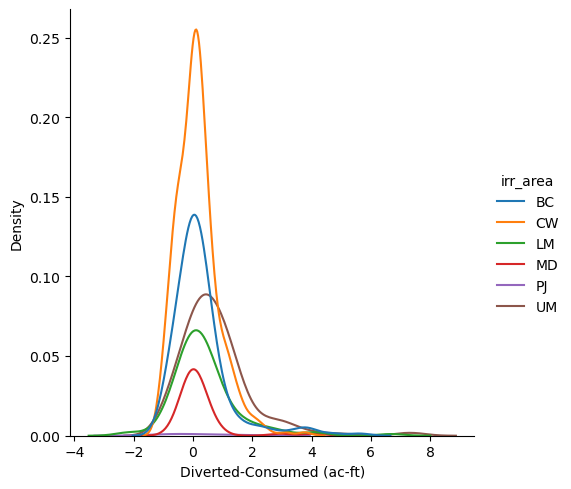

In [19]:

sns.displot(data = data_all, x='ens_resid_pcnt_eet',hue='irr_area',kind="kde" )
plt.xlabel("Diverted-Consumed (ac-ft)")

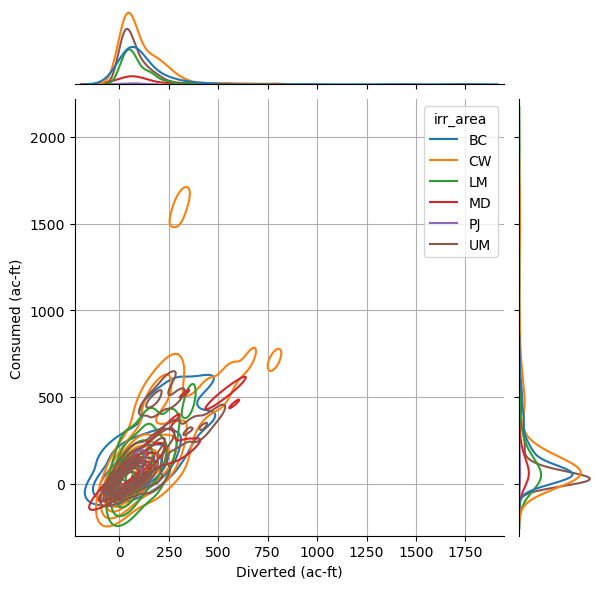

In [20]:

# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=data_all.reset_index(),
    x='total_acft', y='ens_eet', hue='irr_area',
    kind="kde",
)
plt.xlabel("Diverted (ac-ft)")
plt.ylabel("Consumed (ac-ft)")
plt.grid()

Text(0, 0.5, 'Diverted minus Consumed (ac-ft)')

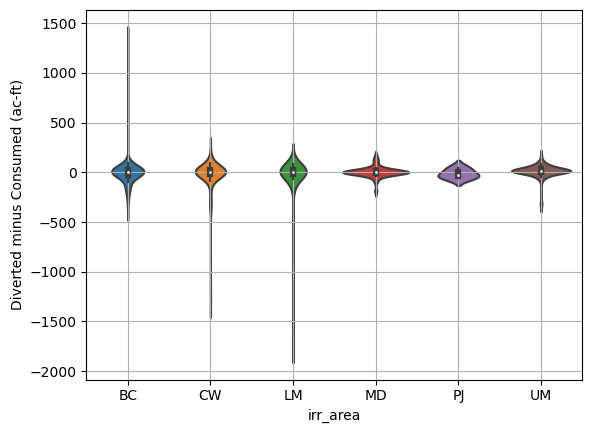

In [21]:
sns.violinplot(data = data_all.reset_index(), x='irr_area', y="ens_residual" )
plt.grid()
plt.ylabel('Diverted minus Consumed (ac-ft)')

In [22]:
data_all.ens_residual.median()

6.453838762868408

In [23]:
data_all.reset_index().to_csv(gispath / 'cottonwood' / "concat_data.csv")

# Merge output with GIS data

In [24]:
data_all_gis = pd.merge(pou_diss['geometry'], data_all.reset_index().set_index(['sensor']), left_index=True,right_index=True)
gis_out = data_all_gis.reset_index().rename(columns={'index':'sensor'}).set_index(['sensor','year'])#.loc['2020']

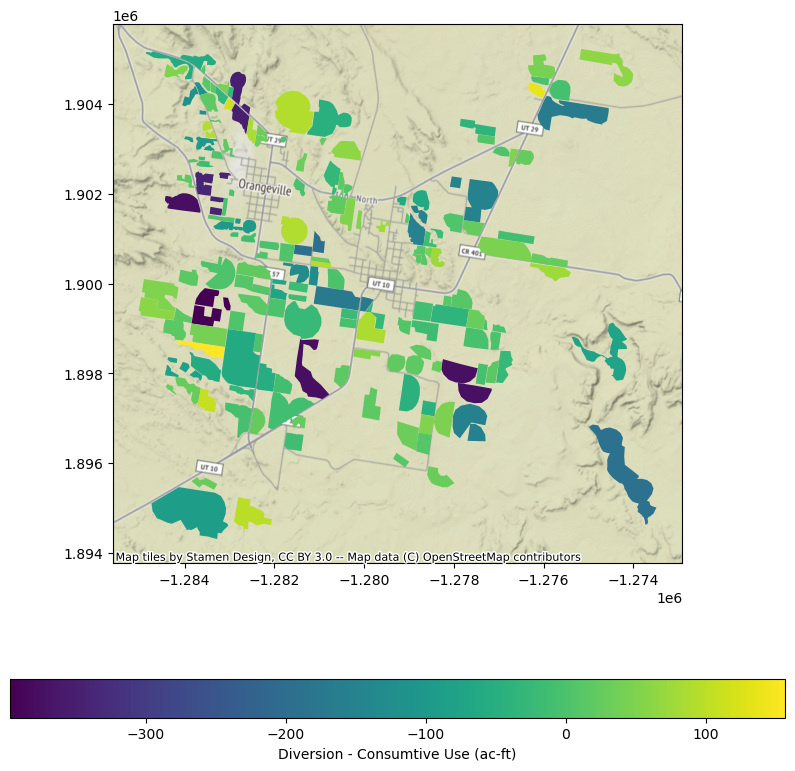

In [25]:

fig, ax = plt.subplots(1,1, figsize=(10,10))

gis_out.query("sensor != 'CW21' and sensor != 'BC45' and year == 2020").plot(column='ens_residual', ax=ax,
                                                                             cmap = "viridis",legend=True,
                        legend_kwds={'label': "Diversion - Consumtive Use (ac-ft)",
                        'orientation': "horizontal"})
cx.add_basemap(ax, crs=gis_out.crs)

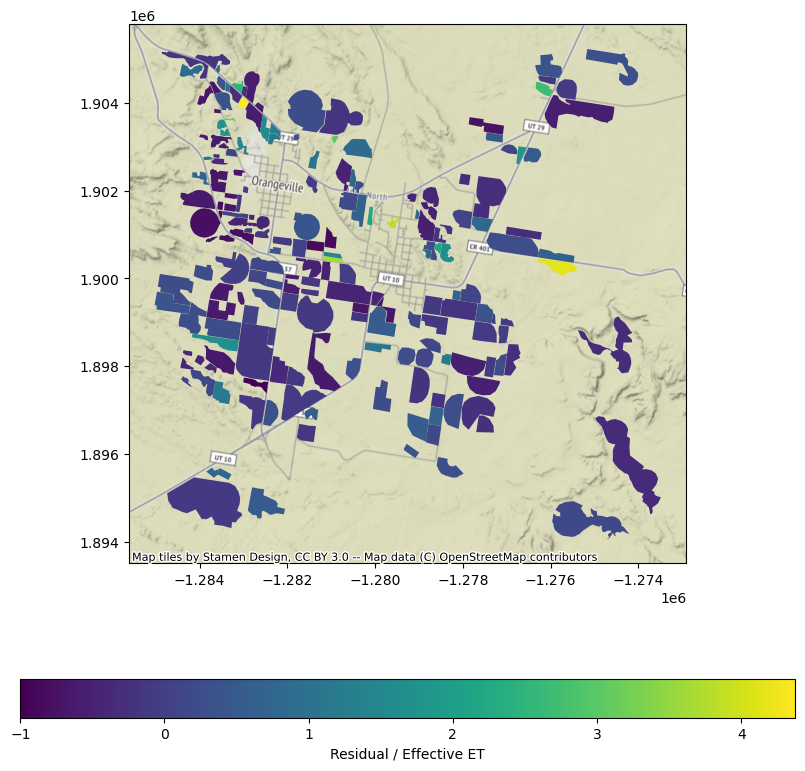

In [26]:

fig, ax = plt.subplots(1,1, figsize=(10,10))
gis_out.query('year == 2020').plot(column='ens_resid_pcnt_eet', cmap = "viridis",ax=ax,
                                   legend=True, legend_kwds={'label': "Residual / Effective ET",
                        'orientation': "horizontal"})
cx.add_basemap(ax, crs=gis_out.crs)

In [46]:

gis_out.loc['BC1']

,geometry,ID,sse_et,ens_etof,ens_eto,ens_et,ens_pr,eem_et,eem_eet,sse_eet,ens_eet,acres,total_acft,page_num,comment,ens_residual,eem_residual,sse_residual,ens_resid_pcnt_eet,irr_area
year,,,,,,,,,,,,,,,,,,,,
2016,"POLYGON Z ((-1281187.607 1900411.275 0.000, -1...",129,21.081757,0.177034,39.153455,25.478082,5.736038,26.640304,20.904266,15.345719,19.742044,10.636613,82.8,11576,NaN,63.057956,61.895734,61.895734,3.194095,BC
2017,"POLYGON Z ((-1281187.607 1900411.275 0.000, -1...",129,21.491250,0.194433,38.197217,26.906996,3.191401,26.618027,23.426627,18.299850,23.715596,10.636613,76.0,11576,NaN,52.284404,52.573373,52.573373,2.204642,BC
2018,"POLYGON Z ((-1281187.607 1900411.275 0.000, -1...",129,22.776177,0.176516,41.903850,26.955243,4.761870,25.330929,20.569059,18.014307,22.193373,10.636613,107.9,11576,NaN,85.706627,87.330941,87.330941,3.861812,BC
2019,"POLYGON Z ((-1281187.607 1900411.275 0.000, -1...",129,23.244125,0.190427,38.223302,26.456024,5.471115,27.798080,22.326965,17.773010,20.984909,10.636613,105.9,11576,NaN,84.915091,83.573035,83.573035,4.046484,BC
2020,"POLYGON Z ((-1281187.607 1900411.275 0.000, -1...",129,26.793599,0.178445,41.730391,27.801918,1.608411,30.162041,28.553630,25.185188,26.193507,10.636613,121.2,11576,NaN,95.006493,92.646370,92.646370,3.627101,BC
2021,"POLYGON Z ((-1281187.607 1900411.275 0.000, -1...",129,21.304574,0.173261,38.880716,24.904146,5.526417,25.688599,20.162182,15.778156,19.377729,10.636613,110.9,11576,NaN,91.522271,90.737818,90.737818,4.723065,BC
2022,"POLYGON Z ((-1281187.607 1900411.275 0.000, -1...",129,22.837338,0.185438,38.609896,26.338648,3.568598,26.712930,23.144331,19.268740,22.770050,10.636613,74.4,11576,NaN,51.629950,51.255669,51.255669,2.267450,BC


In [27]:
gis_out.drop(['comment'],axis=1).to_file(gispath / 'POU_w_data.shp')

C:\Users\paulinkenbrandt\AppData\Local\Temp\ipykernel_7984\2064795904.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gis_out.drop(['comment'],axis=1).to_file(gispath / 'POU_w_data.shp')


# Daily Comparisons

In [33]:
openet_um23 = {}


for file in dlypath.glob("openet_daily_UM23*"):
    year = file.name.split(".")[0].split("_")[-1]
    openet_um23[year] = pd.read_csv(file,index_col="DateTime",parse_dates=True)

oet_daily_um23 = pd.concat(openet_um23).reset_index().set_index('DateTime')
oet_daily_um23 = oet_daily_um23.drop(['level_0','ET Units', 'Source','Method'],axis=1)
area = 152.865551
oet_daily_um23['Ens. ET (ac-ft)'] = (oet_daily_um23['Ensemble ET']*area*0.0833333)
oet_daily_um23['Precip (ac-ft)'] = oet_daily_um23['Precip (gridMET)']*area*0.0833333
oet_daily_um23['Effective ET (ac-ft)'] = oet_daily_um23['Ens. ET (ac-ft)'] - oet_daily_um23['Precip (ac-ft)']
oet_daily_um23['NDVI'].plot()

<AxesSubplot: xlabel='DateTime'>

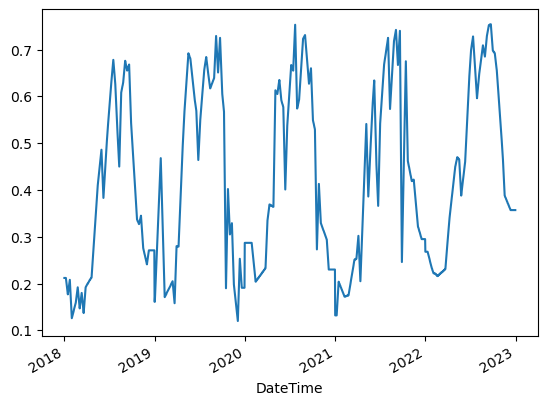

In [36]:
reading_um23 = pd.read_csv(ctnpath / "sensor_values_12346_UM23.csv",parse_dates=True,index_col='datetime')
reading_um23['GPM (gpm)'] = pd.to_numeric(reading_um23['GPM (gpm)'])
reading_um23['GPH'] = reading_um23['GPM (gpm)']*60
reading_dly_um23 = reading_um23.groupby(pd.Grouper(freq='D')).sum()['GPH'].to_frame()
reading_dly_um23['flow acft'] = reading_dly_um23['GPH']*3.06889e-6

In [ ]:
['eeMetric ET', 'SSEBop ET','Ensemble ET']

In [ ]:
reading_dly_um23['flow acft']
oet_daily_um23

(0.0, 10.0)

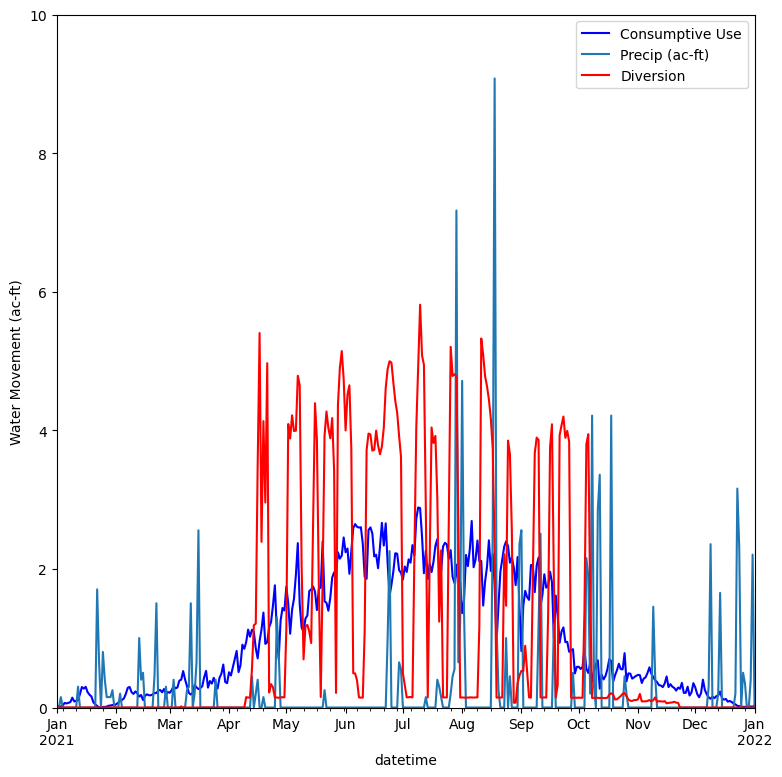

In [41]:
fig, ax = plt.subplots(1,1, figsize=(9,9))

fq = '1D'
oet_daily_um23['Ens. ET (ac-ft)'].groupby(pd.Grouper(freq=fq)).sum().plot(label="Consumptive Use",color='blue',ax=ax)
oet_daily_um23['Precip (ac-ft)'].groupby(pd.Grouper(freq=fq)).sum().plot(ax=ax)
#oet_daily_um23['Effective ET (ac-ft)'].groupby(pd.Grouper(freq=fq)).sum().plot()
plt.ylabel("Water Movement (ac-ft)")
plt.legend(loc=2)
#plt.twinx()




reading_dly_um23['flow acft'].groupby(pd.Grouper(freq=fq)).sum().plot(color='red',label='Diversion', ax=ax)
plt.xlim("2021/01/01","2022/01/01")
#plt.ylabel("Metered Flow (gpm)",color='red')
plt.legend(loc=0)
plt.ylim(0,10)


In [ ]:
fq = '1Y'
oet_daily_um23['Ens. ET (ac-ft)'].groupby(pd.Grouper(freq=fq)).cumsum().plot(label="Consumptive Use",color='blue')
oet_daily_um23['Precip (ac-ft)'].groupby(pd.Grouper(freq=fq)).cumsum().plot()
oet_daily_um23['Effective ET (ac-ft)'].groupby(pd.Grouper(freq=fq)).cumsum().plot()
plt.ylabel("Water Movement (ac-ft)")
plt.legend(loc=2)
#plt.twinx()

reading_dly_um23['flow acft'].groupby(pd.Grouper(freq=fq)).cumsum().plot(color='red',label='Diversion')
plt.xlim("2021/01/01","2022/01/01")
#plt.ylabel("Metered Flow (gpm)",color='red')
plt.legend(loc=0)

In [ ]:
reading_um23['GPM (gpm)']

In [ ]:
from collections import Counter
x = "None,Hay/Turf,Hay/Turf,None,Pasture Land"
data = Counter(x.split(","))

data.most_common(1)[0][0]

* LM19 = only very recently irrigated
* UM6&9 = Fallowed in 2022
* LM13 = recent transition from flood to pivot irrigation
* LM36 = recent transition from flood to pivot irrigation
* BC26 = recent transition from flood to pivot irrigation
* UM31 = recent transition from flood to pivot irrigation

In [ ]:
import ee
import numpy as np
import pandas as pd
import geopandas as gpd

# Create an earth engine feature from a shapely geometry
def get_ee_feature(geom):
    x,y = geom.exterior.coords.xy
    coords = np.dstack((x,y)).tolist()
    g = ee.Geometry.Polygon(coords)
    return ee.Feature(g)

# Create earth engine feature collection from the list of features
features = ee.FeatureCollection([get_ee_feature(x[1].geometry) for x in hexgrid_us.iterrows()])

# Create a single image from image collection and select the band you are interested in
image_collection = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY")
image = image_collection.filterDate('2015-01-01', '2021-12-31').select('temperature_2m').mean()

# Calculate zonal statistics
zone_stats = image.reduceRegions(collection=features, reducer=ee.Reducer.mean(), scale=11132, tileScale=1).getInfo()
zone_stats = gpd.GeoDataFrame.from_features(zone_stats, crs='epsg:4326')

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax= plt.subplots(figsize=(30,26))

# Define the legend axis
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# Plot the U.S. map with hexagons, where the colour represents the mean air temperature
zone_stats.plot(column='mean', ax=ax, cmap='OrRd', legend=True, cax=cax)

# Customise the legend
cax.minorticks_on()
cax.tick_params(which='major', direction='in', length=18, width=2, labelsize=24)
cax.tick_params(which='minor', direction='in', length=12, width=2, labelsize=24)
cax.set_title('Temperature (K)', fontsize=24)

# Turn the x-axis and y-axis off
ax.set_axis_off()

In [ ]:
import folium

temp_map = zone_stats.explore(column='mean', name='Mean Temperature', cmap='OrRd', 
                              style_kwds={'opacity':0.4, 'color':'black', 'opacity':0.2}, 
                              highlight_kwds={'fillOpacity':1}, 
                              tooltip_kwds={'aliases':['Temperature']}, 
                              legend_kwds={'caption':'Mean Temperature (K)'})

# Add layer control to the map
folium.TileLayer('cartodbdark_matter',overlay=True,name="View in Dark Mode").add_to(temp_map)
folium.TileLayer('cartodbpositron',overlay=True,name="View in Light Mode").add_to(temp_map)
folium.LayerControl(collapsed=False).add_to(temp_map)

temp_map

* https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_TERRACLIMATE#bands
* https://developers.google.com/earth-engine/datasets/catalog/NASA_SMAP_SPL4SMGP_007


In [ ]:
ee.ImageCollection("NASA_USDA/HSL/SMAP10KM_soil_moisture")

In [ ]:
NASA/SMAP/SPL4SMGP/007

In [ ]:
IDAHO_EPSCOR/TERRACLIMATE

In [1]:
import ee
ee.Authenticate()

Enter verification code: 4/1AWtgzh4ZkOW14QnZztRy3NLr5qPQDKkA4fKnkScZwVZrNfkK55Yh_2WN5HE

Successfully saved authorization token.


In [18]:

from gee_zonal import ZonalStats
AOIs = ee.FeatureCollection('projects/ee-paulinkenbrandt/assets/cottonwood_pou')
#AOIs = '<path to shapefile>'
zs = ZonalStats(
  collection_id = 'NASA_USDA/HSL/SMAP10KM_soil_moisture',
  target_features = AOIs,
  statistic_type = "mean", # all includes min, max, mean, and stddev
  frequency = "monthly",
  temporal_stat = "mean"
)

In [19]:
res = zs.runZonalStats()

In [20]:
res.to_csv(ctnpath / "cottonwood_SMAP_soil_moisture.csv")

In [21]:

from gee_zonal import ZonalStats
AOIs = ee.FeatureCollection('projects/ee-paulinkenbrandt/assets/cottonwood_pou')
#AOIs = '<path to shapefile>'
zs = ZonalStats(
  collection_id = 'IDAHO_EPSCOR/TERRACLIMATE',
  target_features = AOIs,
  statistic_type = "mean", # all includes min, max, mean, and stddev
  frequency = "monthly",
  temporal_stat = "mean"
)

In [22]:
res = zs.runZonalStats()

In [23]:
res.to_csv(ctnpath / "cottonwood_terra.csv")

In [24]:
res

,1958_10_aet_mean,1958_10_def_mean,1958_10_pdsi_mean,1958_10_pet_mean,1958_10_pr_mean,1958_10_ro_mean,1958_10_soil_mean,1958_10_srad_mean,1958_10_swe_mean,1958_10_tmmn_mean,...,2021_9_vpd_mean,2021_9_vs_mean,Acreage,Croptype,Depletion,Diversion,ID,Meternumbe,Shape_Area,Shape_Leng
00000000000000000000,31.0,944.0,-430.0,975.0,3.0,0,35.0,1785.0,0,4.0,...,172.0,240.0,46.779480,Alfalfa,,,2,CW40,315755.989896,2600.763918
00000000000000000001,31.0,944.0,-430.0,975.0,3.0,0,35.0,1785.0,0,4.0,...,172.0,240.0,29.616903,Alfalfa,,,3,CW27,199936.937966,1794.516594
00000000000000000002,29.0,949.0,-444.0,978.0,3.0,0,24.0,1787.0,0,5.0,...,173.0,240.0,48.352931,Alfalfa,,,4,CW61,326185.208825,2454.469306
00000000000000000003,29.0,949.0,-444.0,978.0,3.0,0,24.0,1787.0,0,5.0,...,173.0,240.0,35.123619,Alfalfa,,,5,CW53,236899.196342,2129.973403
00000000000000000004,29.0,949.0,-444.0,978.0,3.0,0,24.0,1787.0,0,5.0,...,173.0,240.0,34.864141,Alfalfa,,,6,CW52,235161.443135,2714.302002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
000000000000000000e7,31.0,944.0,-430.0,975.0,3.0,0,35.0,1785.0,0,4.0,...,172.0,240.0,0.000000,,,,239,CW21,153791.204724,2001.003010
000000000000000000e8,31.0,944.0,-430.0,975.0,3.0,0,35.0,1785.0,0,4.0,...,172.0,240.0,0.000000,,,,240,CW21,64647.921508,1155.803729
000000000000000000e9,31.0,944.0,-430.0,975.0,3.0,0,35.0,1785.0,0,4.0,...,172.0,240.0,0.000000,,,,241,CW21,26820.774829,905.633405
000000000000000000ea,31.0,944.0,-430.0,975.0,3.0,0,35.0,1785.0,0,4.0,...,172.0,240.0,0.000000,,,,242,CW21,36798.447971,753.258258


In [25]:
AOIs = ee.FeatureCollection('projects/ee-paulinkenbrandt/assets/cottonwood_pou')
#AOIs = '<path to shapefile>'
zs = ZonalStats(
  collection_id = 'OREGONSTATE/PRISM/AN81m',
  target_features = AOIs,
  statistic_type = "mean", # all includes min, max, mean, and stddev
  frequency = "monthly",
  temporal_stat = "mean"
)

res = zs.runZonalStats()
res.to_csv(ctnpath / "cottonwood_PRISM.csv")

In [ ]:
AOIs = ee.FeatureCollection('projects/ee-paulinkenbrandt/assets/cottonwood_pou')
#AOIs = '<path to shapefile>'
zs = ZonalStats(
  collection_id = 'NASA_ORNL_DAYMET_V4',
  target_features = AOIs,
  statistic_type = "mean", # all includes min, max, mean, and stddev
  frequency = "monthly",
  temporal_stat = "mean"
)

res = zs.runZonalStats()
res.to_csv(ctnpath / "cottonwood_DAYMET.csv")

NASA_ORNL_DAYMET_V4

In [ ]:
OREGONSTATE/PRISM/AN81m